# Performing VQA task using Transformers

[vqa-v2-test-std benchmark](https://paperswithcode.com/sota/visual-question-answering-on-vqa-v2-test-std)

Ref.

[Hugging Face : Visual Question Answering](https://huggingface.co/docs/transformers/main/tasks/visual_question_answering)

[HuggingFaceM4/VQAv2](https://huggingface.co/datasets/HuggingFaceM4/VQAv2)

[Fine-tuning ViLT For visual question answering (VQA)](https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/ViLT/Fine_tuning_ViLT_for_VQA.ipynb#scrollTo=XdPv_6rt-soT)

[Hugging Face : ViLT](https://huggingface.co/docs/transformers/main/en/model_doc/vilt)

## Import libraries

In [59]:
# Python version: 3.10.6

import torch
import torch.nn.functional as F
import torch_directml
from datasets import load_dataset
from transformers import (
    ViltProcessor,
    ViltImageProcessor,
    BertTokenizer,
    ViltForQuestionAnswering,
    ViltConfig,
)
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

for i in range(torch_directml.device_count()):
    print(i, ":", torch_directml.device_name(i))

dml = torch_directml.device(1)
print("dml =", dml)

device = "cpu"

0 : Radeon RX 5500M
1 : AMD Radeon(TM) Graphics
dml = privateuseone:1


In [60]:
version = 1
save_model = False
training = False

# Variables

train_loss_history = []
validation_loss_history = []

# Hyperparameter

learning_rate = 5e-5  # 0.00005
epochs = 10
batch_size = 4
dataset = "visual7w-gpt"
# dataset = "vqa"
trained_vqa_model = True

embedding_dim = 40  # do not adjust this parameter

## Load data

In [61]:
train_data = None
validation_data = None
test_data = None

if dataset == "vqa":
    # https://huggingface.co/datasets/HuggingFaceM4/VQAv2
    train_data = load_dataset("HuggingFaceM4/VQAv2", split=f"train[:100]", trust_remote_code=True)
    validation_data = load_dataset("HuggingFaceM4/VQAv2", split=f"validation[:100]", trust_remote_code=True)
    test_data = load_dataset("HuggingFaceM4/VQAv2", split=f"test[:100]", trust_remote_code=True)

elif dataset == "visual7w-gpt":
    # https://huggingface.co/datasets/ruanchaves/visual7w-gpt
    train_data = load_dataset("ruanchaves/visual7w-gpt", split="train[:800]", trust_remote_code=True)
    validation_data = load_dataset("ruanchaves/visual7w-gpt", split="train[800:900]", trust_remote_code=True)
    test_data = load_dataset("ruanchaves/visual7w-gpt", split="train[900:1000]", trust_remote_code=True)

print("Training data:", len(train_data), "Validation data:", len(validation_data))

Training data: 800 Validation data: 100


## EDA & Preprocessing

In [62]:
train_data

Dataset({
    features: ['image', 'image_id', 'question', 'answer', 'label', 'declarative', 'declarative_spelled', 'entailment'],
    num_rows: 800
})

In [63]:
config = ViltConfig.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

### For visual7w-gpt

In [64]:
if dataset == "visual7w-gpt":
    train_data = train_data.filter(lambda x: x["label"] == "True")
    validation_data = validation_data.filter(lambda x: x["label"] == "True")
    test_data = test_data.filter(lambda x: x["label"] == "True")

    def preprocessing_label(instance):
        answer = instance["answer"]
        instance["labels"] = [config.label2id[answer]]
        instance["decoded_labels"] = answer
        instance["scores"] = [1]

        return instance

    train_data = train_data.map(preprocessing_label)
    validation_data = validation_data.map(preprocessing_label)
    test_data = test_data.map(preprocessing_label)

    print("Training data:", len(train_data), "Validation data:", len(validation_data), "Test data", len(test_data))

Training data: 200 Validation data: 26 Test data 25


### For VQAv2

In [65]:
if dataset == "vqa":

    def get_score(count: int) -> float:
        return min(1.0, count / 3)

    def add_label_score(sample):
        answers = sample["answers"]
        answer_count = {}
        for answer in answers:
            answer_ = answer["answer"]
            answer_count[answer_] = answer_count.get(answer_, 0) + 1
        labels = []
        decoded_labels = []
        scores = []
        for answer in answer_count:
            if answer not in list(config.label2id.keys()):
                continue
            labels.append(config.label2id[answer])
            decoded_labels.append(answer)
            score = get_score(answer_count[answer])
            scores.append(score)

        sample["labels"] = labels
        sample["decoded_labels"] = decoded_labels
        sample["scores"] = scores

        return sample

    train_data = train_data.map(add_label_score)
    validation_data = validation_data.map(add_label_score)

In [66]:
# Ref. https://huggingface.co/google-bert/bert-base-uncased

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
encoded_question = tokenizer.encode(train_data[0]["question"])
decoded_question = tokenizer.decode(encoded_question)

print("original question:", train_data[0]["question"])
print("encoded question:", encoded_question)
print("decoded question:", decoded_question)

original question: How many windows are visible on the side of the bus?
encoded question: [101, 2129, 2116, 3645, 2024, 5710, 2006, 1996, 2217, 1997, 1996, 3902, 1029, 102]
decoded question: [CLS] how many windows are visible on the side of the bus? [SEP]


In [67]:
# Ref. https://huggingface.co/dandelin/vilt-b32-mlm

image_processor = ViltImageProcessor.from_pretrained("dandelin/vilt-b32-mlm")
processed_image = image_processor(train_data[0]["image"])
print(processed_image.keys())

dict_keys(['pixel_values', 'pixel_mask'])


In [68]:
processed_image['pixel_values']

[array([[[-0.24705881, -0.32549018, -0.64705884, ...,  0.41960788,
           0.41960788,  0.41176474],
         [-0.654902  , -0.67058825, -0.827451  , ...,  0.41960788,
           0.41960788,  0.41176474],
         [-0.09803921, -0.6784314 , -0.8509804 , ...,  0.427451  ,
           0.41960788,  0.41960788],
         ...,
         [-0.01176471, -0.0745098 , -0.04313725, ..., -0.3098039 ,
          -0.3098039 , -0.3098039 ],
         [-0.00392157, -0.1607843 , -0.08235294, ..., -0.26274508,
          -0.27058822, -0.27058822],
         [-0.0745098 , -0.2862745 , -0.15294117, ..., -0.19999999,
          -0.19999999, -0.19999999]],
 
        [[-0.18431371, -0.25490195, -0.5686275 , ...,  0.6156863 ,
           0.6156863 ,  0.60784316],
         [-0.5921569 , -0.6       , -0.7490196 , ...,  0.6156863 ,
           0.6156863 ,  0.60784316],
         [-0.03529412, -0.60784316, -0.77254903, ...,  0.62352943,
           0.6156863 ,  0.6156863 ],
         ...,
         [-0.04313725, -0.1058823

In [69]:
processed_image['pixel_mask']

[array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=int64)]

In [70]:
processor = ViltProcessor(image_processor, tokenizer)

In [71]:
class VQADataset(torch.utils.data.Dataset):
    """VQA (v2) dataset."""

    def __init__(self, samples, processor):
        self.processor = processor
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # get image + text
        image = self.samples[idx]["image"].convert("RGB")
        text = self.samples[idx]["question"]

        encoding = self.processor(
            image, text, padding="max_length", max_length=embedding_dim, truncation=True, return_tensors="pt"
        )

        # remove batch dimension
        for k, v in encoding.items():
            encoding[k] = v.squeeze()

        # add labels
        labels = self.samples[idx]["labels"]
        scores = self.samples[idx]["scores"]

        # based on: https://github.com/dandelin/ViLT/blob/762fd3975c180db6fc88f577cf39549983fa373a/vilt/modules/objectives.py#L301

        targets = torch.zeros(len(config.id2label))

        for label, score in zip(labels, scores):
            targets[label] = score

        encoding["labels"] = targets

        return encoding

In [72]:
train_dataset = VQADataset(train_data, processor)
validation_dataset = VQADataset(validation_data, processor)

In [73]:
train_dataset[0].keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'pixel_mask', 'labels'])

In [74]:
train_dataset[0]["input_ids"]

tensor([ 101, 2129, 2116, 3645, 2024, 5710, 2006, 1996, 2217, 1997, 1996, 3902,
        1029,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])

## Build model

In [75]:
# Ref. https://huggingface.co/dandelin/vilt-b32-finetuned-vqa
model = None

if trained_vqa_model:
  model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa", config=config)
else:
  model = ViltForQuestionAnswering(config=config)

model.to(device)

c:\Users\User\Desktop\Deep_Learning\.venv\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


ViltForQuestionAnswering(
  (vilt): ViltModel(
    (embeddings): ViltEmbeddings(
      (text_embeddings): TextEmbeddings(
        (word_embeddings): Embedding(30522, 768)
        (position_embeddings): Embedding(40, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (patch_embeddings): ViltPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      )
      (token_type_embeddings): Embedding(2, 768)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViltEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViltLayer(
          (attention): ViltAttention(
            (attention): ViltSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=76

## Batch data

In [76]:
from torch.utils.data import DataLoader


def collate_fn(batch):
    input_ids = [item["input_ids"] for item in batch]
    pixel_values = [item["pixel_values"] for item in batch]
    attention_mask = [item["attention_mask"] for item in batch]
    token_type_ids = [item["token_type_ids"] for item in batch]
    labels = [item["labels"] for item in batch]

    # create padded pixel values and corresponding pixel mask
    encoding = processor.image_processor.pad(pixel_values, return_tensors="pt")

    # create new batch
    batch = {}
    batch["input_ids"] = torch.stack(input_ids)
    batch["attention_mask"] = torch.stack(attention_mask)
    batch["token_type_ids"] = torch.stack(token_type_ids)
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = torch.stack(labels)

    return batch


train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=False)

In [77]:
batch = next(iter(train_dataloader))

for k, v in batch.items():
    print(k, v.shape)

input_ids torch.Size([4, 40])
attention_mask torch.Size([4, 40])
token_type_ids torch.Size([4, 40])
pixel_values torch.Size([4, 3, 576, 576])
pixel_mask torch.Size([4, 576, 576])
labels torch.Size([4, 3129])


## Training

In [78]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


def training_step(data_loader):

    model.train()

    losses = 0

    with tqdm(total=len(data_loader)) as progress:
        for batch in data_loader:
            # get the inputs;
            batch = {k: v.to(device) for k, v in batch.items()}

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(**batch)

            loss = outputs.loss
            losses += loss.item()

            progress.set_description(f"Loss: {loss.item()}")

            loss.backward()

            optimizer.step()

            progress.update()

    train_loss_history.append(losses / len(data_loader))


def evaluation_step(data_loader):
    model.eval()

    losses = 0

    with tqdm(total=len(data_loader)) as progress:
        for batch in data_loader:
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch)

            loss = outputs.loss

            progress.set_description(f"Loss: {loss.item()}")

            losses += loss.item()

            progress.update()

    validation_loss_history.append(losses / len(data_loader))


if training:
    for epoch in range(epochs):

        print(f"Epoch: {epoch}")

        print("Training step")
        training_step(train_dataloader)

        print("Validation step")
        evaluation_step(validation_dataloader)

## Evaluation

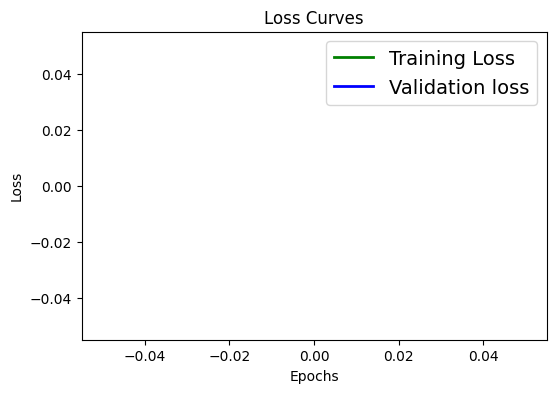

In [79]:
plt.figure(figsize=[6, 4])
plt.plot(train_loss_history, "green", linewidth=2.0)
plt.plot(validation_loss_history, "blue", linewidth=2.0)
plt.legend(["Training Loss", "Validation loss"], fontsize=14)
plt.xlabel("Epochs", fontsize=10)
plt.ylabel("Loss", fontsize=10)
plt.title("Loss Curves", fontsize=12)
plt.show()

## Insights

In [80]:
if save_model:
    torch.save(model.state_dict(), f"./models/state_dict/vqa-trainsformer-{version}.pth")

In [81]:
# model = ViltForQuestionAnswering(config=config)
# state = torch.load(f"./models/state_dict/vqa-trainsformer-{version}.pth")
# model.load_state_dict(state)


model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa", config=config)

### Test with test data

In [82]:
# 0, 12
index = 4
data = validation_data

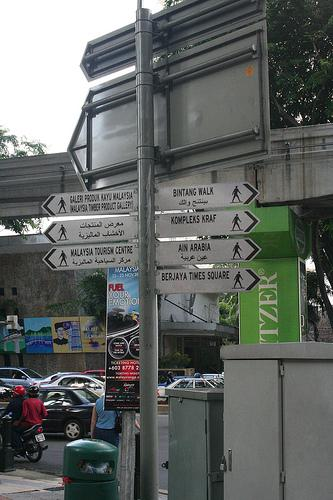

In [83]:
data[index]['image']

In [84]:
data[index]['question']

'How many signfronts point to the left?'

In [85]:
data[index]['answer']

'3'

In [112]:
dataset = VQADataset(data, processor)
encoding = dataset[index]

# for k, v in encoding.items():
#     print(k, v.shape)

encoding = {k: v[None, :].to(device) for k, v in encoding.items()}

outputs = model(**encoding)
logits = outputs.logits
predicted_classes = torch.sigmoid(logits)
probs, classes = torch.topk(predicted_classes, 5)

for prob, class_idx in zip(probs.squeeze().tolist(), classes.squeeze().tolist()):
    print(prob, model.config.id2label[class_idx])

loss = outputs.loss
targets = dataset[index]["labels"]

term1 = F.binary_cross_entropy_with_logits(logits, targets.unsqueeze(0))
targets_dim = targets.shape[0]
vqa_loss = term1 * targets_dim

print(
    "Loss from model outputs:",
    loss.item(),
    "\nBinary cross entropy loss:",
    term1.item(),
    "\nTargets dimension",
    targets_dim,
    "\nCompute VQA loss:",
    vqa_loss.item(),
)

0.36361467838287354 4
0.3290449380874634 3
0.31899213790893555 5
0.2506045401096344 6
0.16123820841312408 2
Loss from model outputs: 2.8167471885681152 
Binary cross entropy loss: 0.0009002068545669317 
Targets dimension 3129 
Compute VQA loss: 2.8167471885681152
